In [2]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
import shap

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.outcomes import OutcomesProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%reload_ext autoreload
%reload_ext nb_black

2022-03-18 09:11:29.139640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/nfs/home/subasriv/.conda/envs/vector_delirium/lib/python3.8/site-packages/cv2/../../lib64:/opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-03-18 09:11:29.139700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-18 09:11:33.785915: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 09:11:33.786282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpu1.gemini-hpc.ca): /proc/driver/nvidia/version does not exist
2022-03-18 0

<IPython.core.display.Javascript object>

## Load Data ##

In [3]:
cfg = config.read_config("../../configs/default/*.yaml")
db = Database(cfg)

EXTRACT_SAVE_PATH = "/mnt/nfs/project/delirium/_extract/first_models/extract.h5"

2022-03-18 09:11:39,719 INFO cyclops.orm     - Database setup, ready to run queries!


<IPython.core.display.Javascript object>

In [4]:
%autoreload 2

data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin")
must_have_columns = [ENCOUNTER_ID, AGE, SEX]

admin_processor = AdminProcessor(data, must_have_columns)
admin_features = admin_processor.process()

2022-03-18 09:11:39,907 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:11:39,911 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:11:39,914 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:11:52,742 INFO cyclops.utils.profile - Finished executing function process in 12.819247 s


<IPython.core.display.Javascript object>

In [5]:
%autoreload 2
labs = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin_labs")
must_have_columns = [
    ENCOUNTER_ID,
    ADMIT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
]
labs_processor = LabsProcessor(labs, must_have_columns)
labs_features = labs_processor.process()

2022-03-18 09:11:59,490 INFO cyclops.processors.base - Processing raw lab data...
2022-03-18 09:11:59,519 INFO cyclops.processors.base - # samples: 1290086, # encounters: 10688
2022-03-18 09:12:00,252 INFO cyclops.processors.base - Aggregating labs within aggregation window...
2022-03-18 09:12:00,260 INFO cyclops.processors.base - # samples: 482354, # encounters: 10653
2022-03-18 09:12:01,773 INFO cyclops.processors.base - Remove text in parentheses and normalize lab test names...
2022-03-18 09:12:01,782 INFO cyclops.processors.base - # samples: 482354, # encounters: 10653
2022-03-18 09:12:02,236 INFO cyclops.processors.base - Drop unsupported...
2022-03-18 09:12:02,258 INFO cyclops.processors.base - # samples: 410025, # encounters: 10653
2022-03-18 09:12:03,882 INFO cyclops.processors.base - Fixing inequalities and removing outlier values...
2022-03-18 09:12:03,889 INFO cyclops.processors.base - # samples: 410025, # encounters: 10653
2022-03-18 09:12:04,019 INFO cyclops.processors.bas

<IPython.core.display.Javascript object>

In [6]:
%autoreload 2
vitals = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin_vitals")
must_have_columns = [
    ENCOUNTER_ID,
    ADMIT_TIMESTAMP,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    REFERENCE_RANGE,
]

vitals_processor = VitalsProcessor(vitals, must_have_columns)
vitals_features = vitals_processor.process()

2022-03-18 09:14:41,446 INFO cyclops.processors.base - Processing raw vitals data...
2022-03-18 09:14:41,475 INFO cyclops.processors.base - # samples: 594190, # encounters: 3082
2022-03-18 09:14:41,671 INFO cyclops.processors.base - Aggregating vitals within aggregation window...
2022-03-18 09:14:41,675 INFO cyclops.processors.base - # samples: 74304, # encounters: 3014
2022-03-18 09:14:41,914 INFO cyclops.processors.base - Drop oxygen flow rate, saturation samples (unsupported)...
2022-03-18 09:14:41,918 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-18 09:14:42,267 INFO cyclops.processors.base - Convert Positive/Negative to 1/0...
2022-03-18 09:14:42,270 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-18 09:14:42,283 INFO cyclops.processors.base - Fill empty result string values with NaN...
2022-03-18 09:14:42,301 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-18 09:14:42,313 INFO cyclops.processors

<IPython.core.display.Javascript object>

In [7]:
%autoreload 2

admin_data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin")
los_er_data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_los_er")

data = pd.merge(admin_data, los_er_data, how="outer")
must_have_columns = [
    ENCOUNTER_ID,
    AGE,
    SEX,
    DISCHARGE_DISPOSITION,
    LENGTH_OF_STAY_IN_ER,
]
outcomes_processor = OutcomesProcessor(data, must_have_columns)
outcome_targets = outcomes_processor.process()

2022-03-18 09:14:54,367 INFO cyclops.processors.base - Processing raw outcomes data...
2022-03-18 09:14:54,385 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:14:54,423 INFO cyclops.utils.profile - Finished executing function process in 0.056225 s


<IPython.core.display.Javascript object>

In [8]:
feature_handler = FeatureHandler()
feature_handler.add_features(admin_features)
feature_handler.add_features(labs_features)
feature_handler.add_features(vitals_features)
feature_handler.add_features(outcome_targets)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


<IPython.core.display.Javascript object>

In [9]:
pd.set_option("display.max_columns", None)
feature_handler.features.head()

,age,sex,aptt,ketone,bilirubin,calcium,"calcium, ionized",creatinine,esr,serum alcohol,ferritin,fibrinogen,glucose fasting,glucose point of care,glucose random,hematocrit,hemoglobin,crp,influenza,inr,lactate arterial,lactate venous,mean cell volume,arterial paco2,venous pco2,arterial ph,venous ph,platelet count,arterial pao2,potassium,pt,sodium,urine sodium,urine specific gravity,bicarbonate,troponin,blood urea nitrogen,vitamin b12,white blood cell count,high sensitivity troponin,vitamin d,hba1c,lymphocyte,neutrophils,albumin,Heart Rate,respiratory rate,Systolic BP,CAM,Diastolic BP,Temperature,weight,fio2,mortality_in_hospital,length_of_stay_in_er
11100040,84,1,27.7,NaN,NaN,1.69,NaN,664.0,NaN,NaN,NaN,NaN,NaN,12.675,13.2,0.2880,95.5,NaN,NaN,1.14,NaN,NaN,102.45,NaN,NaN,NaN,NaN,112.5,NaN,3.70,12.65,131.5,NaN,NaN,20.5,NaN,NaN,NaN,8.500,NaN,NaN,NaN,1.110,6.445,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15.400000
11100097,65,1,NaN,NaN,9.5,2.25,NaN,42.5,NaN,NaN,NaN,NaN,NaN,NaN,9.4,0.4565,146.5,NaN,NaN,NaN,NaN,2.30,99.70,NaN,38.0,NaN,7.45,274.5,NaN,4.85,NaN,130.5,NaN,1.015,23.0,0.006000,NaN,NaN,12.715,NaN,NaN,NaN,1.630,9.830,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16.816668
11100164,59,1,25.1,NaN,8.0,2.25,NaN,95.0,NaN,1.0,NaN,3.16,NaN,NaN,6.5,0.4400,145.5,NaN,NaN,0.96,NaN,1.20,86.35,NaN,47.0,NaN,7.35,224.0,NaN,4.10,10.70,134.5,NaN,NaN,24.5,NaN,NaN,NaN,7.260,NaN,NaN,0.055,0.955,5.755,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.650000
11100176,63,1,25.6,NaN,NaN,2.26,NaN,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3285,98.5,NaN,NaN,0.99,NaN,NaN,69.15,NaN,NaN,NaN,NaN,407.5,NaN,5.00,10.90,134.5,NaN,NaN,23.0,0.006000,NaN,NaN,10.280,NaN,NaN,NaN,1.020,7.615,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.350000
11100374,46,1,NaN,NaN,11.0,2.47,NaN,23.5,NaN,1.0,NaN,NaN,NaN,NaN,7.0,0.4810,152.0,NaN,NaN,NaN,NaN,1.55,91.20,43.0,58.5,7.37,7.33,270.0,67.0,4.65,NaN,136.0,NaN,1.013,29.0,0.035667,NaN,232.0,14.190,NaN,NaN,NaN,1.015,12.075,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24.250000


<IPython.core.display.Javascript object>

In [10]:
x = feature_handler.features
x_ind = (
    x[list(vitals_features.columns.values) + list(labs_features.columns.values)]
    .isnull()
    .astype(int)
    .add_suffix("_indicator")
)
X = pd.concat([x, x_ind], axis=1)
X = X[X["length_of_stay_in_er"].notna()]
feat = feature_handler.features.isnull().sum(axis=0).sort_values(ascending=False)
feat_remov = feat[feat > 5000].index
X = X.drop(feat_remov, axis=1)
# X = X.dropna()
X = X.fillna(X.mean())
X.head()

,age,sex,bilirubin,calcium,creatinine,glucose random,hematocrit,hemoglobin,mean cell volume,platelet count,potassium,sodium,bicarbonate,white blood cell count,lymphocyte,neutrophils,albumin,mortality_in_hospital,length_of_stay_in_er,Heart Rate_indicator,respiratory rate_indicator,Systolic BP_indicator,CAM_indicator,Diastolic BP_indicator,Temperature_indicator,weight_indicator,fio2_indicator,aptt_indicator,ketone_indicator,bilirubin_indicator,calcium_indicator,"calcium, ionized_indicator",creatinine_indicator,esr_indicator,serum alcohol_indicator,ferritin_indicator,fibrinogen_indicator,glucose fasting_indicator,glucose point of care_indicator,glucose random_indicator,hematocrit_indicator,hemoglobin_indicator,crp_indicator,influenza_indicator,inr_indicator,lactate arterial_indicator,lactate venous_indicator,mean cell volume_indicator,arterial paco2_indicator,venous pco2_indicator,arterial ph_indicator,venous ph_indicator,platelet count_indicator,arterial pao2_indicator,potassium_indicator,pt_indicator,sodium_indicator,urine sodium_indicator,urine specific gravity_indicator,bicarbonate_indicator,troponin_indicator,blood urea nitrogen_indicator,vitamin b12_indicator,white blood cell count_indicator,high sensitivity troponin_indicator,vitamin d_indicator,hba1c_indicator,lymphocyte_indicator,neutrophils_indicator,albumin_indicator
11100040,84,1,16.889285,1.69,664.0,13.200000,0.2880,95.5,102.45,112.5,3.70,131.5,20.5,8.500,1.110,6.445,28.0,0,15.400000,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,0,1,1,1,0,0,0
11100097,65,1,9.500000,2.25,42.5,9.400000,0.4565,146.5,99.70,274.5,4.85,130.5,23.0,12.715,1.630,9.830,30.0,0,16.816668,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,0,0
11100164,59,1,8.000000,2.25,95.0,6.500000,0.4400,145.5,86.35,224.0,4.10,134.5,24.5,7.260,0.955,5.755,44.0,0,3.650000,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,0
11100176,63,1,16.889285,2.26,312.0,8.149029,0.3285,98.5,69.15,407.5,5.00,134.5,23.0,10.280,1.020,7.615,33.0,0,8.350000,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,1,1,1,0,0,0
11100374,46,1,11.000000,2.47,23.5,7.000000,0.4810,152.0,91.20,270.0,4.65,136.0,29.0,14.190,1.015,12.075,41.0,0,24.250000,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1,0,0,0


<IPython.core.display.Javascript object>

In [11]:
ids_precovid = data.loc[
    data["admit_timestamp"].dt.date < datetime.date(2020, 3, 1), "encounter_id"
]
X_train = X.loc[X.index.isin(ids_precovid)]
# label_column specifies the index of the column containing the true label
y_train = np.where(X_train["length_of_stay_in_er"] > 7, 1, 0)
X_train = X_train.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.67)

ids_covid = data.loc[
    data["admit_timestamp"].dt.date > datetime.date(2020, 2, 28), "encounter_id"
]
X_test = X.loc[X.index.isin(ids_covid)]
y_test = np.where(X_test["length_of_stay_in_er"] > 7, 1, 0)
X_test = X_test.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_test.head()

,age,sex,bilirubin,calcium,creatinine,glucose random,hematocrit,hemoglobin,mean cell volume,platelet count,potassium,sodium,bicarbonate,white blood cell count,lymphocyte,neutrophils,albumin,Heart Rate_indicator,respiratory rate_indicator,Systolic BP_indicator,CAM_indicator,Diastolic BP_indicator,Temperature_indicator,weight_indicator,fio2_indicator,aptt_indicator,ketone_indicator,bilirubin_indicator,calcium_indicator,"calcium, ionized_indicator",creatinine_indicator,esr_indicator,serum alcohol_indicator,ferritin_indicator,fibrinogen_indicator,glucose fasting_indicator,glucose point of care_indicator,glucose random_indicator,hematocrit_indicator,hemoglobin_indicator,crp_indicator,influenza_indicator,inr_indicator,lactate arterial_indicator,lactate venous_indicator,mean cell volume_indicator,arterial paco2_indicator,venous pco2_indicator,arterial ph_indicator,venous ph_indicator,platelet count_indicator,arterial pao2_indicator,potassium_indicator,pt_indicator,sodium_indicator,urine sodium_indicator,urine specific gravity_indicator,bicarbonate_indicator,troponin_indicator,blood urea nitrogen_indicator,vitamin b12_indicator,white blood cell count_indicator,high sensitivity troponin_indicator,vitamin d_indicator,hba1c_indicator,lymphocyte_indicator,neutrophils_indicator,albumin_indicator
11101884,54,1,17.5,2.300000,55.0,6.766667,0.479333,172.666667,92.30,145.333333,3.366667,132.333333,22.333333,13.030,1.006667,10.780,37.0,0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,0
11102331,94,1,8.0,2.223746,87.0,8.000000,0.350000,113.000000,102.00,158.000000,3.800000,142.000000,26.000000,7.340,0.870000,5.380,34.0,0,0,0,1,0,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0
11103929,62,1,17.5,2.380000,78.5,7.250000,0.432000,154.000000,86.25,211.000000,3.250000,132.000000,25.000000,15.135,0.495000,13.765,44.0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0
11104009,57,1,12.0,2.230000,65.0,4.300000,0.411000,143.000000,93.95,158.500000,3.900000,136.500000,26.500000,7.010,1.255000,4.975,39.0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0
11105030,35,1,6.0,2.223746,73.0,5.100000,0.461500,158.000000,95.35,222.000000,4.400000,136.000000,28.500000,7.955,0.665000,6.720,39.0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,0,0


<IPython.core.display.Javascript object>

## Modeling ## 

### MLP ###

In [12]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import roc_auc_score


def fit_MLP(X, Y, Xv, Yv):
    best_c = None
    best_score = 0
    best_model = None
    for c in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
        m = MLP(
            hidden_layer_sizes=(256, 256, 256, 256),
            alpha=c,
            early_stopping=True,
            learning_rate="adaptive",
            batch_size=128,
        )
        m.fit(X.values, Y)
        Pv = m.predict_proba(Xv.values)[:, 1]
        score = roc_auc_score(Yv, Pv)
        print("Fitted model with C:", c, "AUC:", score)
        if score > best_score:
            best_score = score
            best_model = m
            best_c = c

    print("Best C:", best_c, "AUC:", best_score)
    return best_model


optimised_mlp = fit_MLP(X_train, y_train, X_val, y_val)

Fitted model with C: 0.1 AUC: 0.5584394006614147
Fitted model with C: 0.01 AUC: 0.5462309790245635
Fitted model with C: 0.001 AUC: 0.5220032628849488
Fitted model with C: 0.0001 AUC: 0.5319085755898734
Fitted model with C: 1e-05 AUC: 0.5512013108101181
Fitted model with C: 1e-06 AUC: 0.5146803309548091
Fitted model with C: 1e-07 AUC: 0.5342647108210768
Best C: 0.1 AUC: 0.5584394006614147


<IPython.core.display.Javascript object>

In [13]:
y_pred = optimised_mlp.predict(X_test.values)
compute_threshold_metric(y_test, y_pred, 0.5)

Sensitivity: 1.0
Specificity: 0.0
Positive Predictive Value: 0.9092409240924092
False Positive Rate: 1.0
False Negative Rate: 0.0
Accuracy: 0.9092409240924092


<IPython.core.display.Javascript object>

X has feature names, but MLPClassifier was fitted without feature names
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


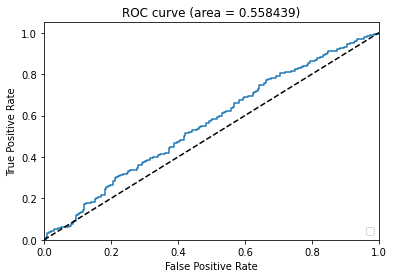

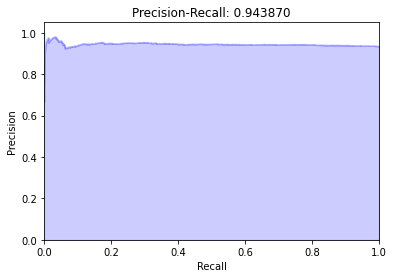

<IPython.core.display.Javascript object>

In [14]:
y_pred_prob = optimised_mlp.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

X has feature names, but MLPClassifier was fitted without feature names
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


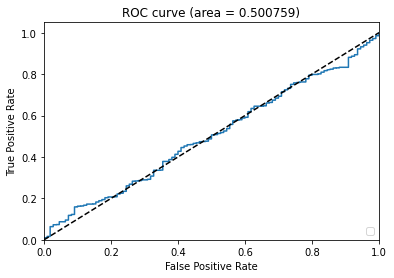

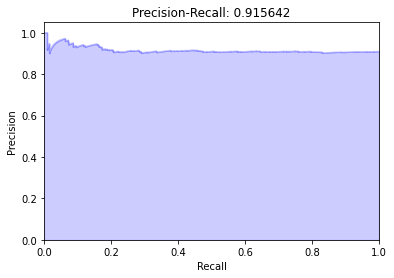

<IPython.core.display.Javascript object>

In [15]:
y_pred_prob = optimised_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

### Random Forest ###

In [16]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score


def fit_rf(X, Y, Xv, Yv):
    best_n = None
    best_score = 0
    best_model = None
    for n in [5, 10, 50, 100, 500]:
        m = RF(n_estimators=n, n_jobs=-1)
        print("Fitting model with n:", n)
        m.fit(X, Y)
        Pv = m.predict_proba(Xv)[:, 1]
        score = roc_auc_score(Yv, Pv)
        if score > best_score:
            best_score = score
            best_model = m
            best_n = n

    print("Best n:", best_n)
    return best_model


optimised_rf = fit_rf(X_train, y_train, X_val, y_val)

Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


<IPython.core.display.Javascript object>

In [17]:
y_pred = optimised_rf.predict(X_test)
print_metrics(y_test, y_pred)

Sensitivity: 0.9990925589836661
Specificity: 0.00909090909090909
Positive Predictive Value: 0.9099173553719008
False Positive Rate: 0.990909090909091
False Negative Rate: 0.0009074410163339383
Accuracy: 0.9092409240924092


<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


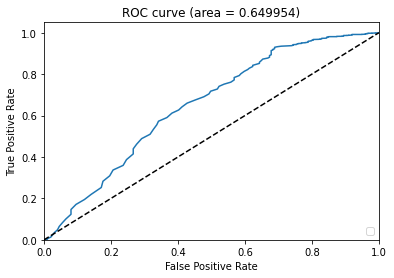

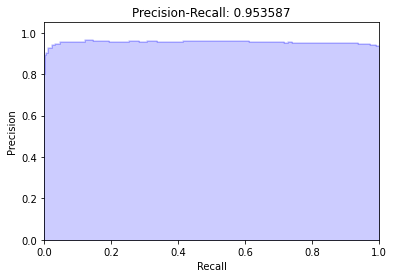

<IPython.core.display.Javascript object>

In [18]:
y_pred_prob = optimised_rf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


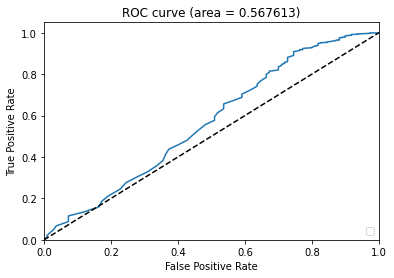

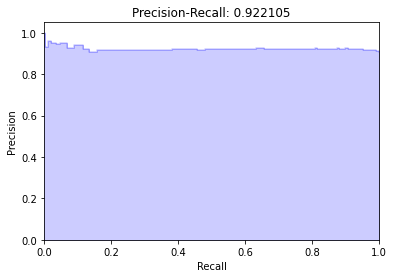

<IPython.core.display.Javascript object>

In [19]:
y_pred_prob = optimised_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

### Gradient Boosted Tree ###

In [20]:
X = pd.concat([x, x_ind], axis=1)
feat_remov = feat[feat > 9000].index
X = X.drop(feat_remov, axis=1)

X_train = X.loc[X.index.isin(ids_precovid)]
# label_column specifies the index of the column containing the true label
y_train = np.where(X_train["length_of_stay_in_er"] > 7, 1, 0)
X_train = X_train.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.67)
X_test = X.loc[X.index.isin(ids_covid)]
y_test = np.where(X_test["length_of_stay_in_er"] > 7, 1, 0)
X_test = X_test.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])

<IPython.core.display.Javascript object>

In [21]:
from xgboost import XGBClassifier


def fit_xgb(X, Y, Xv, Yv):
    best_n = None
    best_g = None
    best_score = 0
    best_model = None
    for n in [3, 5, 7, 9, 11]:
        for g in [0.5, 1, 1.5, 2, 5]:
            m = XGBClassifier(
                max_depth=n,
                gamma=g,
                objective="binary:logistic",
                learning_rate=0.1,
                eval_metric="logloss",
                min_child_weight=1,
                seed=42,
                use_label_encoder=False,
            )
            # print("Fitting model with n: {} and g: {}".format(n, g))
            m.fit(X, Y)
            Pv = m.predict_proba(Xv)[:, 1]
            score = roc_auc_score(Yv, Pv)
            if score > best_score:
                best_score = score
                best_model = m
                best_n = n
                best_g = g
    print("Best g:", best_g)
    print("Best n:", best_n)
    return best_model


optimised_xgb = fit_xgb(X_train, y_train, X_val, y_val)

Best g: 5
Best n: 11


<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


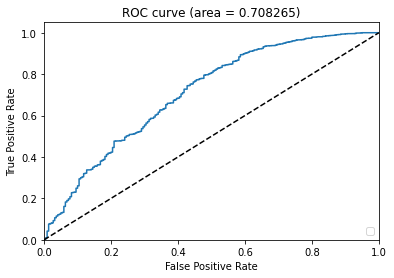

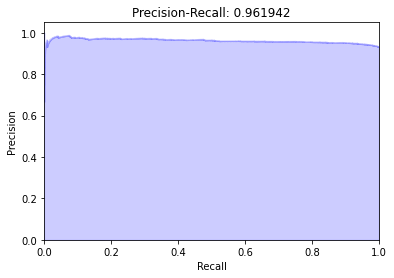

<IPython.core.display.Javascript object>

In [22]:
y_pred_prob = optimised_xgb.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


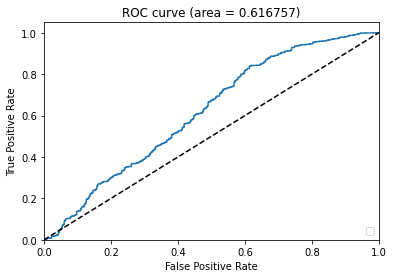

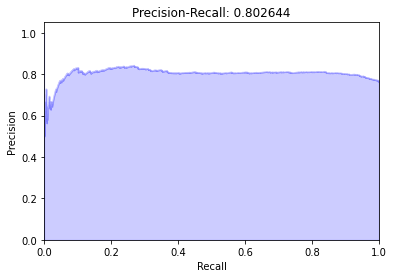

<IPython.core.display.Javascript object>

In [23]:
y_pred_prob = optimised_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

# Drift Tests #

In [26]:
path = "/path/"
dataset = "gemini"
samples = [10, 20, 50, 100, 200, 500, 1000, 2000]
# Number of random runs to average results over.
random_runs = 5
# Significance level.
sign_level = 0.05
# Whether to calculate accuracy for malignancy quantification.
calc_acc = True
na_cutoff = 4000
dr_techniques = ["NoRed", "PCA", "BBSDs_FFNN"]  # ,"SRP","kPCA","Isomap"]
# Statistical Tests
md_tests = ["MMD", "LSDD"]

<IPython.core.display.Javascript object>

In [27]:
times = ["pre-covid", "covid"]
mean_dr_md = np.ones((len(times), len(dr_techniques), len(md_tests), len(samples))) * (
    -1
)
std_dr_md = np.ones((len(times), len(dr_techniques), len(md_tests), len(samples))) * (
    -1
)

for ti, time in enumerate(times):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            mean_p_vals, std_p_vals = run_shift_experiment(
                time,
                path,
                dr_technique,
                md_test,
                samples,
                dataset,
                sign_level,
                na_cutoff,
                features,
                random_runs,
                calc_acc=True,
            )
            mean_dr_md[ti, di, mi, :] = mean_p_vals
            std_dr_md[ti, di, mi, :] = std_p_vals

Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:26:24,876 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:26:24,879 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:26:24,882 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:26:36,261 INFO cyclops.utils.profile - Finished executing function process in 11.384994 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475


2022-03-18 09:27:13,731 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:27:13,743 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:27:13,746 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:27:24,909 INFO cyclops.utils.profile - Finished executing function process in 11.177785 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426


2022-03-18 09:28:01,919 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:28:01,922 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:28:01,925 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:28:13,044 INFO cyclops.utils.profile - Finished executing function process in 11.124924 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185


2022-03-18 09:28:49,348 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:28:49,354 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:28:49,357 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:29:00,589 INFO cyclops.utils.profile - Finished executing function process in 11.241354 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612


2022-03-18 09:29:37,055 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:29:37,073 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:29:37,076 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:29:48,633 INFO cyclops.utils.profile - Finished executing function process in 11.577936 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:30:19,589 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:30:19,593 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756


Shift p-vals:  0.5699999928474426
Shift pre-covid


2022-03-18 09:30:19,599 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:30:31,939 INFO cyclops.utils.profile - Finished executing function process in 12.349803 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:30:33,883 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:30:33,887 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:30:33,890 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8600000143051147


2022-03-18 09:30:45,808 INFO cyclops.utils.profile - Finished executing function process in 11.925184 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:30:47,738 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:30:47,742 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:30:47,745 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8600000143051147


2022-03-18 09:30:59,659 INFO cyclops.utils.profile - Finished executing function process in 11.920287 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:31:01,709 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:31:01,713 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:31:01,717 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.17000000178813934


2022-03-18 09:31:14,050 INFO cyclops.utils.profile - Finished executing function process in 12.341344 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:31:16,028 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:31:16,032 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:31:16,035 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.9700000286102295


2022-03-18 09:31:25,234 INFO cyclops.utils.profile - Finished executing function process in 9.206662 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:31:26,255 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:31:26,259 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:31:26,262 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.9800000190734863
Shift pre-covid


2022-03-18 09:31:31,797 INFO cyclops.utils.profile - Finished executing function process in 5.541952 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:31:53,864 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:31:53,868 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:31:53,871 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1899999976158142


2022-03-18 09:32:00,232 INFO cyclops.utils.profile - Finished executing function process in 6.368167 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:32:18,822 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:32:18,826 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:32:18,829 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3700000047683716


2022-03-18 09:32:24,701 INFO cyclops.utils.profile - Finished executing function process in 5.879508 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:32:40,584 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:32:40,588 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:32:40,591 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.2800000011920929


2022-03-18 09:32:46,164 INFO cyclops.utils.profile - Finished executing function process in 5.580431 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:33:07,694 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:33:07,698 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:33:07,702 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.07999999821186066


2022-03-18 09:33:13,609 INFO cyclops.utils.profile - Finished executing function process in 5.914892 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:33:31,825 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:33:31,839 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:33:31,843 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:33:37,854 INFO cyclops.utils.profile - Finished executing function process in 6.028810 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:33:38,991 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:33:38,995 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:33:38,999 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.17000000178813934


2022-03-18 09:33:44,819 INFO cyclops.utils.profile - Finished executing function process in 5.828031 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:33:45,994 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:33:45,999 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:33:46,002 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.14000000059604645


2022-03-18 09:33:51,818 INFO cyclops.utils.profile - Finished executing function process in 5.823082 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:33:52,970 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:33:52,974 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:33:52,978 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.03999999910593033


2022-03-18 09:33:59,487 INFO cyclops.utils.profile - Finished executing function process in 6.516362 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:34:00,624 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:34:00,628 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:34:00,631 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.07000000029802322


2022-03-18 09:34:06,183 INFO cyclops.utils.profile - Finished executing function process in 5.559075 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:34:07,526 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:34:07,528 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:34:07,530 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:34:13,597 INFO cyclops.utils.profile - Finished executing function process in 6.070965 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:34:31,733 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:34:31,740 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:34:31,743 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.019999999552965164


2022-03-18 09:34:37,773 INFO cyclops.utils.profile - Finished executing function process in 6.040185 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:34:56,056 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:34:56,061 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:34:56,065 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.5199999809265137


2022-03-18 09:35:01,759 INFO cyclops.utils.profile - Finished executing function process in 5.703254 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:35:20,126 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:35:20,132 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:35:20,135 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.03999999910593033


2022-03-18 09:35:25,898 INFO cyclops.utils.profile - Finished executing function process in 5.771905 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:35:42,165 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:35:42,170 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:35:42,173 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3100000023841858


2022-03-18 09:35:48,215 INFO cyclops.utils.profile - Finished executing function process in 6.049607 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:36:03,497 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:03,503 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:03,506 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.6399999856948853
Shift pre-covid


2022-03-18 09:36:09,654 INFO cyclops.utils.profile - Finished executing function process in 6.156559 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:36:10,790 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:10,794 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:10,798 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.17000000178813934


2022-03-18 09:36:17,957 INFO cyclops.utils.profile - Finished executing function process in 7.166700 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716


2022-03-18 09:36:19,924 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:19,927 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:19,930 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:36:26,313 INFO cyclops.utils.profile - Finished executing function process in 6.389037 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:36:27,364 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:27,368 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:27,372 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8500000238418579


2022-03-18 09:36:32,920 INFO cyclops.utils.profile - Finished executing function process in 5.555997 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:36:33,970 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:33,976 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:33,979 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.5899999737739563


2022-03-18 09:36:39,493 INFO cyclops.utils.profile - Finished executing function process in 5.522784 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:36:40,544 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:36:40,548 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:36:40,551 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.4099999964237213
Shift covid


2022-03-18 09:36:46,441 INFO cyclops.utils.profile - Finished executing function process in 5.897337 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:37:00,931 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:37:00,934 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:37:00,936 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.14000000059604645


2022-03-18 09:37:07,042 INFO cyclops.utils.profile - Finished executing function process in 6.110989 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:37:21,399 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:37:21,404 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:37:21,407 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-18 09:37:26,923 INFO cyclops.utils.profile - Finished executing function process in 5.523217 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:37:41,309 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:37:41,314 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:37:41,317 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.10000000149011612


2022-03-18 09:37:47,092 INFO cyclops.utils.profile - Finished executing function process in 5.783580 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746


2022-03-18 09:38:00,948 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:38:00,951 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:38:00,954 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:38:07,321 INFO cyclops.utils.profile - Finished executing function process in 6.372969 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:38:21,511 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:38:21,515 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:38:21,518 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.15000000596046448
Shift covid


2022-03-18 09:38:27,293 INFO cyclops.utils.profile - Finished executing function process in 5.782751 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:38:28,736 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:38:28,740 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:38:28,743 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-18 09:38:34,277 INFO cyclops.utils.profile - Finished executing function process in 5.541485 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0


2022-03-18 09:38:36,287 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:38:36,291 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:38:36,294 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:38:48,147 INFO cyclops.utils.profile - Finished executing function process in 11.859644 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0


2022-03-18 09:38:51,051 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:38:51,055 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:38:51,058 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:39:03,121 INFO cyclops.utils.profile - Finished executing function process in 12.068686 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0


2022-03-18 09:39:06,624 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:39:06,628 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:39:06,632 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:39:18,798 INFO cyclops.utils.profile - Finished executing function process in 12.172487 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:39:21,908 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:39:21,911 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:39:21,915 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:39:33,811 INFO cyclops.utils.profile - Finished executing function process in 11.903225 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104


2022-03-18 09:40:04,595 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:40:04,600 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:40:04,603 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:40:16,262 INFO cyclops.utils.profile - Finished executing function process in 11.666995 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0


2022-03-18 09:40:46,311 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:40:46,315 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:40:46,318 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:40:57,640 INFO cyclops.utils.profile - Finished executing function process in 11.328658 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25


2022-03-18 09:41:27,539 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:41:27,542 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:41:27,545 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:41:38,829 INFO cyclops.utils.profile - Finished executing function process in 11.289832 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806


2022-03-18 09:42:08,960 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:42:08,964 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:42:08,967 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-18 09:42:20,247 INFO cyclops.utils.profile - Finished executing function process in 11.286746 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:42:40,327 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:42:40,331 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:42:40,335 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.17000000178813934
Shift covid


2022-03-18 09:42:45,887 INFO cyclops.utils.profile - Finished executing function process in 5.559713 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:42:47,605 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:42:47,609 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:42:47,613 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.5400000214576721


2022-03-18 09:42:53,126 INFO cyclops.utils.profile - Finished executing function process in 5.521015 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:42:54,925 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:42:54,929 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:42:54,932 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-18 09:43:00,684 INFO cyclops.utils.profile - Finished executing function process in 5.758954 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:43:02,432 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:43:02,436 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:43:02,439 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.17000000178813934


2022-03-18 09:43:07,998 INFO cyclops.utils.profile - Finished executing function process in 5.566329 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:43:09,717 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:43:09,721 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:43:09,724 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.09000000357627869


2022-03-18 09:43:15,405 INFO cyclops.utils.profile - Finished executing function process in 5.688461 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:43:17,187 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:43:17,191 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:43:17,194 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1599999964237213
Shift covid


2022-03-18 09:43:22,704 INFO cyclops.utils.profile - Finished executing function process in 5.516767 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:43:37,139 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:43:37,144 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:43:37,147 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.6700000166893005


2022-03-18 09:43:42,888 INFO cyclops.utils.profile - Finished executing function process in 5.749211 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:43:57,564 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:43:57,569 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:43:57,572 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.25999999046325684


2022-03-18 09:44:03,037 INFO cyclops.utils.profile - Finished executing function process in 5.473140 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:44:17,463 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:44:17,468 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:44:17,471 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3799999952316284


2022-03-18 09:44:23,792 INFO cyclops.utils.profile - Finished executing function process in 6.328860 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:44:38,169 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:44:38,174 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:44:38,177 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.009999999776482582


2022-03-18 09:44:43,981 INFO cyclops.utils.profile - Finished executing function process in 5.812043 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-18 09:44:58,462 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:44:58,466 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:44:58,470 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0
Shift covid


2022-03-18 09:45:04,062 INFO cyclops.utils.profile - Finished executing function process in 5.600496 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:45:05,619 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:45:05,623 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:45:05,626 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.019999999552965164


2022-03-18 09:45:11,173 INFO cyclops.utils.profile - Finished executing function process in 5.554929 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:45:12,706 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:45:12,710 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:45:12,714 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.009999999776482582


2022-03-18 09:45:18,399 INFO cyclops.utils.profile - Finished executing function process in 5.692955 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:45:19,933 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:45:19,938 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:45:19,941 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.2800000011920929


2022-03-18 09:45:25,691 INFO cyclops.utils.profile - Finished executing function process in 5.757893 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-18 09:45:27,221 INFO cyclops.processors.base - Processing raw admin data...
2022-03-18 09:45:27,226 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-18 09:45:27,229 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-18 09:45:33,292 INFO cyclops.utils.profile - Finished executing function process in 6.071724 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513


<IPython.core.display.Javascript object>

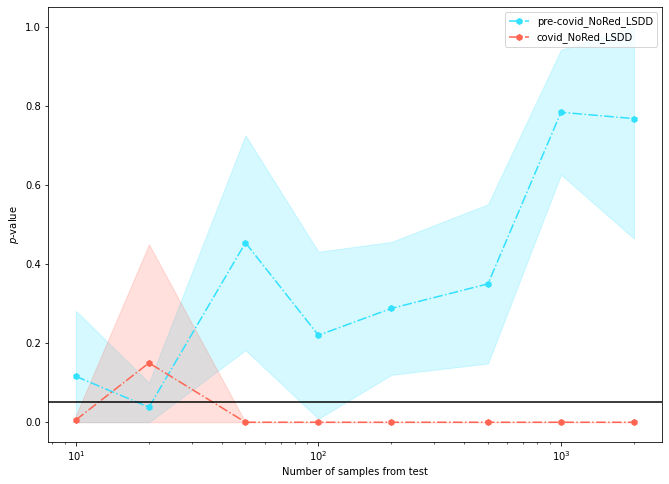

<IPython.core.display.Javascript object>

In [28]:
fig = plt.figure(figsize=(11, 8))
for ti, time in enumerate(times):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            if di == 0 and mi == 1:
                errorfill(
                    np.array(samples),
                    mean_dr_md[ti, di, mi, :],
                    std_dr_md[ti, di, mi, :],
                    fmt=linestyles[mi] + markers[mi],
                    color=colorscale(colors[ti], brightness[di]),
                    label="%s" % "_".join([time, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test")
plt.ylabel("$p$-value")
plt.axhline(y=sign_level, color="k")
plt.legend()
plt.show()

In [1]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X)